In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import bicgstab
import Reader as rd
from glob import glob
import matplotlib.patches as patches
import pandas as pd
import math
from scipy.misc import imread
import bcolz

import os

#### Methods

$normalization = v^{T}Dv$

$correlation = \frac{(v^{T}Ds)^2} {normalization}$

$score = \frac{v^{T}Lv}{normalization}$

In [2]:
def e_neighbour_graph(img, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            result[row * colN + col][(row + rowDiff) * colN + (col + colDiff)] = 1
    return result


def fully_connected_graph(img, sigma):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for row2 in range(rowN):
                for col2 in range(colN):
                    weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                    result[row * colN + col][row2 * colN + col2] = weight
    return result


def fully_connected_e_neighbour_graph(img, sigma, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            row2 = row + rowDiff
                            col2 = col + colDiff
                            weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                            result[row * colN + col][row2 * colN + col2] = weight
    return result

def laplacian(graph):
    diag = np.diag(sum(graph))
    lap = diag - graph
    return [lap, diag]


def orthogonalize(diag, s):
    nodeNum = len(diag)
    p = np.ones((nodeNum, 1)) / pow(sum(np.diag(np.diag(sum(diag)))), .5)
    projection = np.dot(np.transpose(s), np.dot(diag, p))
    v = s - projection[0][0] * p
    # return [v, projection]
    return v


def PRwalk(graph, alpha, s):
    if alpha < 0:
        print('Error: alpha must be positive!')
        return -1
    nodeNum = len(graph)
    [L, D] = laplacian(graph)
    s = orthogonalize(D, s)
    v, flag = bicgstab((L + alpha * D), np.dot(D, s),tol=1e-3, maxiter=nodeNum)

    v = np.reshape(v, (len(v), 1))

    v = orthogonalize(D, v)
    return v

def PRobjective(graph, seed, myImg):
    
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    print('Threshold: ' + str(1 / len(graph)))
    alphaList = []    
    correlationList = []
    scoreList = []
    valueList = []
    
    exponential = 1
    correlation = 1 / len(graph) + 1 # to get into loop
    
    MAXITER = 29
    MINITER = 4
    for i in range(MAXITER):
        if correlation > 1 / len(graph):
            oldCorrelation = correlation
            exponential -= 1
            alpha = 2 ** exponential
            v = PRwalk(graph, alpha, s)
            normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
            correlation = \
                (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
            score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
            alphaList.append(alpha)
            correlationList.append(correlation)
            scoreList.append(score)
            valueList.append(v)
            
            print('--')
            print('alpha: 2^' + str(exponential))
            print('Correlation: ' + str(correlation))
            print('Score: ' + str(score))
            print('Heatmap:\n')
            heat = np.zeros(myImg.shape)
            for ii in range(myImg.shape[0]):
                for jj in range(myImg.shape[1]):
                    heat[ii][jj] = v[ii * myImg.shape[1] + jj]    
            plt.imshow(heat, cmap='hot', interpolation='nearest')
            plt.show()
            
        if i == MINITER:
            print('**')
            print('Starting correlation decrease check!')
            
        if i >= MINITER and oldCorrelation * .99 < correlation:
            break
            
    print('****')
    plt.plot(correlationList, scoreList, 'r*--')
    plt.xlabel('Correlation')
    plt.ylabel('Score')
    plt.show()
    
    return [alphaList, correlationList, scoreList, valueList]

def normalize(D, s):
    norm = np.dot(np.dot(np.transpose(s), D), s)
    v = s/math.sqrt(norm)
    return v

def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

#### Image

In [3]:
# 0cc6fc725d4b8818415ddc06823fce98
IMAGE = "0cc6fc725d4b8818415ddc06823fce98"
myImg = np.asarray(imread(IMAGE + "/" + IMAGE + ".aps.jpg"), dtype=np.int)
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
# 140 row, 156 columns
seedList = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1']
for i in range(30, 111, 32):
    for j in range(50, 111, 30):
        seedList.append([i,j])
alphaListList = []
correlationListList = []
scoreListList = []
valueListList = []

#### Trying seed as normalised full image

$seed[i] = \frac{intensity[i]}{\sqrt{\sum intensity^2}}$

Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.999869561584
Score: 0.0013423222989
Heatmap:



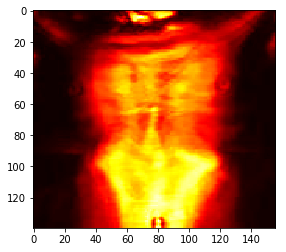

--
alpha: 2^-1
Correlation: 0.999692339887
Score: 0.00122141707317
Heatmap:



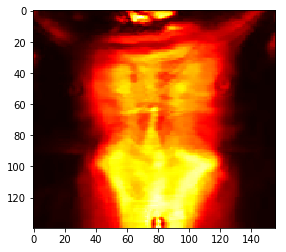

--
alpha: 2^-2
Correlation: 0.999339919624
Score: 0.00109906642623
Heatmap:



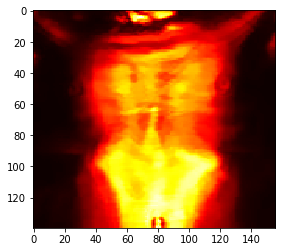

--
alpha: 2^-3
Correlation: 0.998666345269
Score: 0.000980892779547
Heatmap:



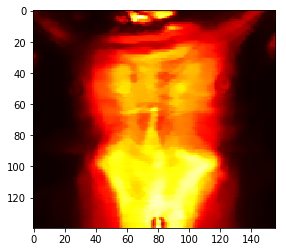

--
alpha: 2^-4
Correlation: 0.997412253385
Score: 0.000870284559473
Heatmap:



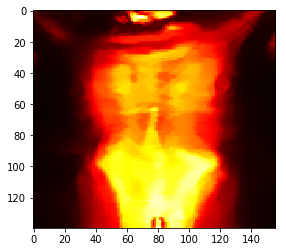

**
Starting correlation decrease check!
****


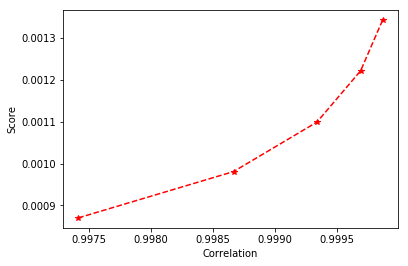

In [4]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed / math.sqrt(sum(sum(seed * seed)))

[alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

# Saving
alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

#### Trying seed as normalised Intensity Square to between 0 and 1

$seed[i] = \frac{intensity[i]^2 - min(intensity^2)}{max(intensity^2) - min(intensity^2)}$

Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.999782247764
Score: 0.00196792088806
Heatmap:



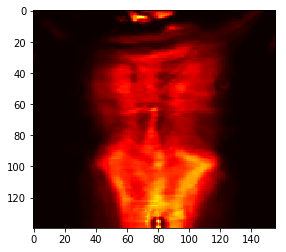

--
alpha: 2^-1
Correlation: 0.999468561582
Score: 0.00175290546134
Heatmap:



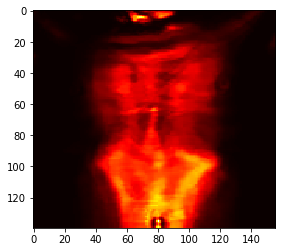

--
alpha: 2^-2
Correlation: 0.998814887826
Score: 0.00152515418827
Heatmap:



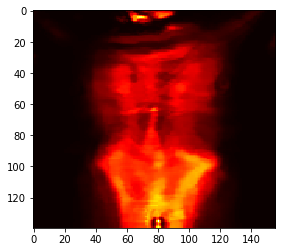

--
alpha: 2^-3
Correlation: 0.99750932064
Score: 0.00129618193164
Heatmap:



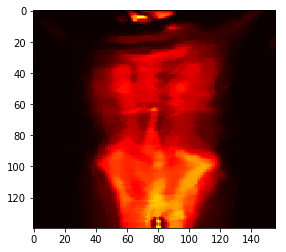

--
alpha: 2^-4
Correlation: 0.995039670258
Score: 0.00107728114754
Heatmap:



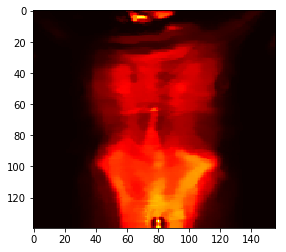

**
Starting correlation decrease check!
****


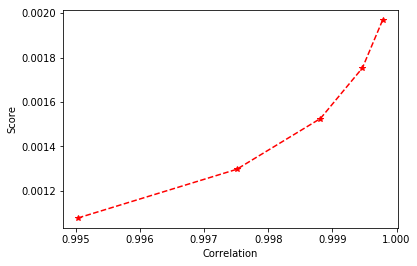

In [5]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed * seed
seed = (seed - min(seed)) / (max(seed) - min(seed))

[alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

# Saving
alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

#### Trying seedList that is randomly taken in and outside of threat

--------Seed [30, 50]
Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.973101176082
Score: 0.853345723433
Heatmap:



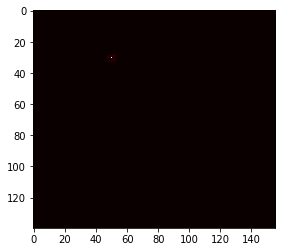

--
alpha: 2^-1
Correlation: 0.925417698221
Score: 0.777985762423
Heatmap:



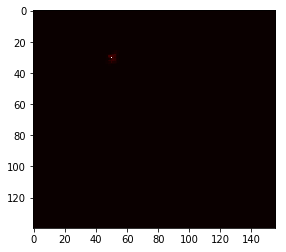

--
alpha: 2^-2
Correlation: 0.823364491774
Score: 0.654250243311
Heatmap:



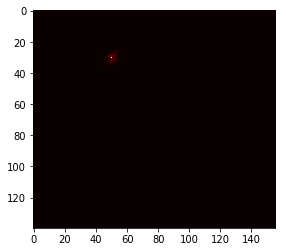

--
alpha: 2^-3
Correlation: 0.658214038912
Score: 0.488355693817
Heatmap:



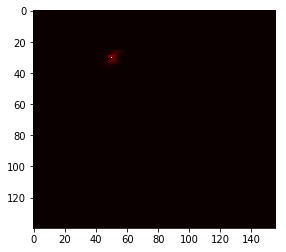

--
alpha: 2^-4
Correlation: 0.464747295132
Score: 0.31929044401
Heatmap:



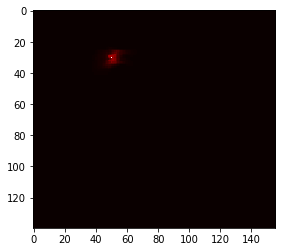

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.298159742414
Score: 0.18919421165
Heatmap:



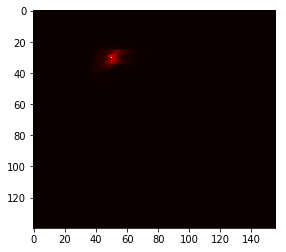

--
alpha: 2^-6
Correlation: 0.183432285943
Score: 0.107943948301
Heatmap:



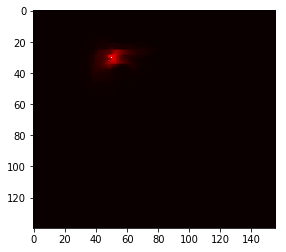

--
alpha: 2^-7
Correlation: 0.114092776985
Score: 0.0629609639599
Heatmap:



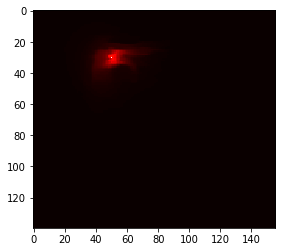

--
alpha: 2^-8
Correlation: 0.0730836174459
Score: 0.0383331881645
Heatmap:



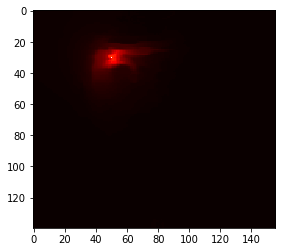

--
alpha: 2^-9
Correlation: 0.0483400810672
Score: 0.0244003408745
Heatmap:



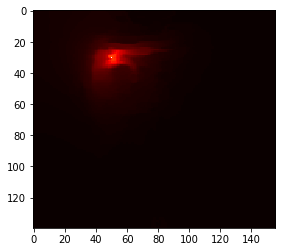

--
alpha: 2^-10
Correlation: 0.031124795167
Score: 0.0152010265135
Heatmap:



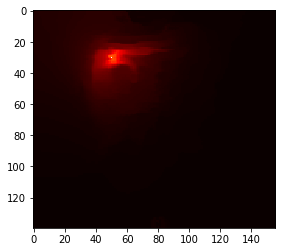

--
alpha: 2^-11
Correlation: 0.02004226227
Score: 0.00952578251086
Heatmap:



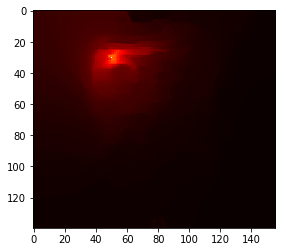

--
alpha: 2^-12
Correlation: 0.013222814427
Score: 0.00615559050774
Heatmap:



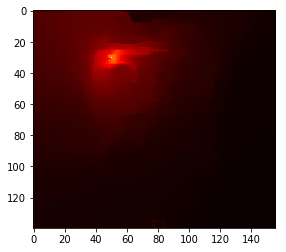

--
alpha: 2^-13
Correlation: 0.00927659715831
Score: 0.00425643773797
Heatmap:



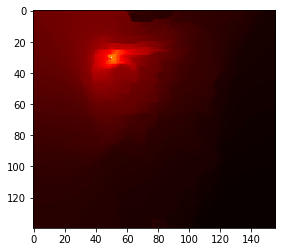

--
alpha: 2^-14
Correlation: 0.00708763073237
Score: 0.00322448548164
Heatmap:



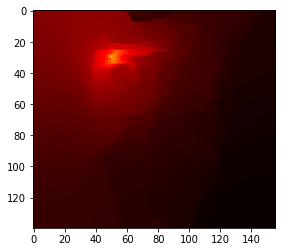

--
alpha: 2^-15
Correlation: 0.005626246558
Score: 0.00254392034444
Heatmap:



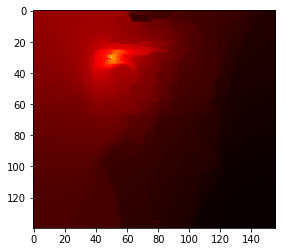

--
alpha: 2^-16
Correlation: 0.00507045704479
Score: 0.00229013422615
Heatmap:



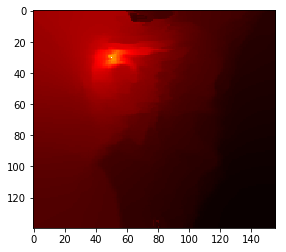

--
alpha: 2^-17
Correlation: 0.00494500320404
Score: 0.00223252076159
Heatmap:



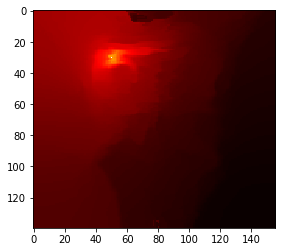

--
alpha: 2^-18
Correlation: 0.00467682320278
Score: 0.00211011193127
Heatmap:



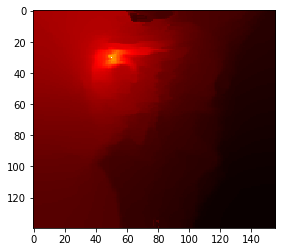

--
alpha: 2^-19
Correlation: 0.00464958581609
Score: 0.00209761026301
Heatmap:



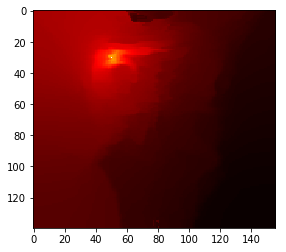

****


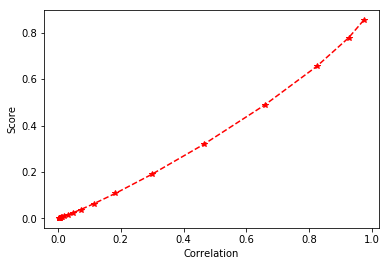

--------Seed [30, 80]
Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.966654723343
Score: 0.825879078855
Heatmap:



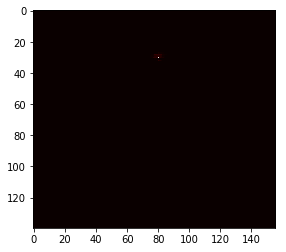

--
alpha: 2^-1
Correlation: 0.906992912901
Score: 0.732788167259
Heatmap:



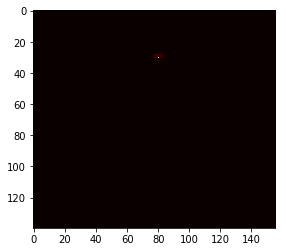

--
alpha: 2^-2
Correlation: 0.784290965508
Score: 0.587186623116
Heatmap:



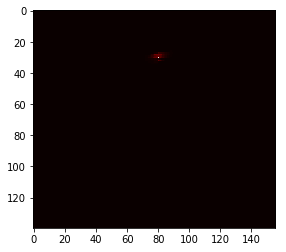

--
alpha: 2^-3
Correlation: 0.602103306804
Score: 0.410601052796
Heatmap:



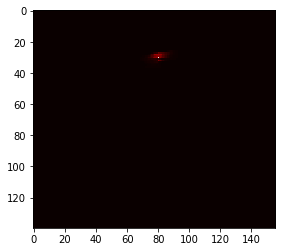

--
alpha: 2^-4
Correlation: 0.413269768104
Score: 0.254497508141
Heatmap:



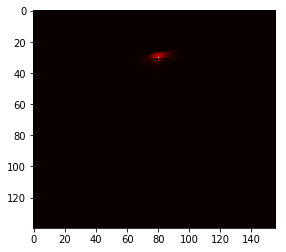

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.266297643194
Score: 0.148401492317
Heatmap:



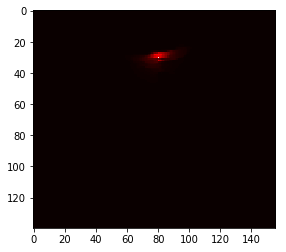

--
alpha: 2^-6
Correlation: 0.168103093834
Score: 0.0855642900038
Heatmap:



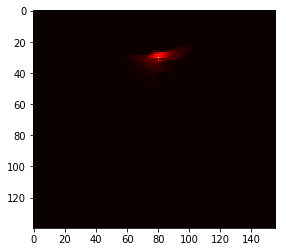

--
alpha: 2^-7
Correlation: 0.106487715744
Score: 0.0501534896522
Heatmap:



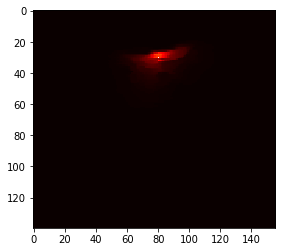

--
alpha: 2^-8
Correlation: 0.0687709683892
Score: 0.0304246283278
Heatmap:



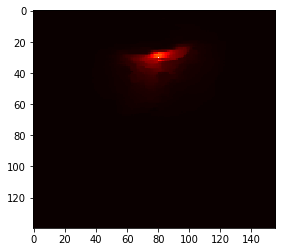

--
alpha: 2^-9
Correlation: 0.0455362640928
Score: 0.0191979588385
Heatmap:



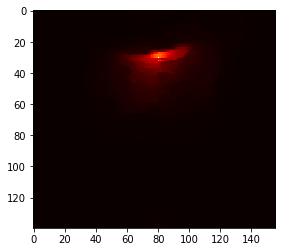

--
alpha: 2^-10
Correlation: 0.0311278288717
Score: 0.0126701033456
Heatmap:



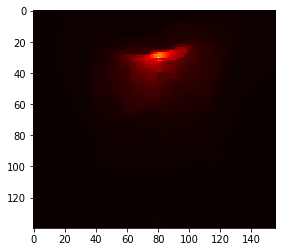

--
alpha: 2^-11
Correlation: 0.0223868391467
Score: 0.00890591172756
Heatmap:



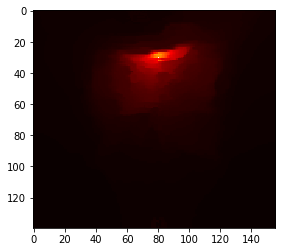

--
alpha: 2^-12
Correlation: 0.0175503959706
Score: 0.00689892984599
Heatmap:



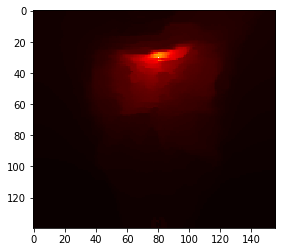

--
alpha: 2^-13
Correlation: 0.0146938350348
Score: 0.00574216762219
Heatmap:



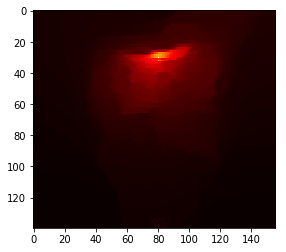

--
alpha: 2^-14
Correlation: 0.013627504213
Score: 0.00531761921336
Heatmap:



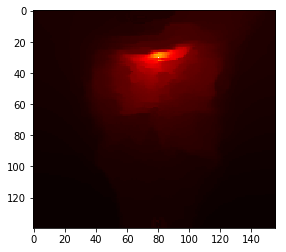

--
alpha: 2^-15
Correlation: 0.0128052304191
Score: 0.00499207316368
Heatmap:



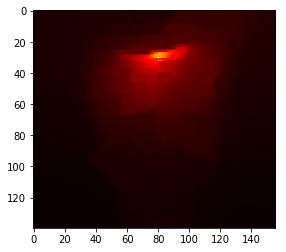

--
alpha: 2^-16
Correlation: 0.0123822217196
Score: 0.00482567453137
Heatmap:



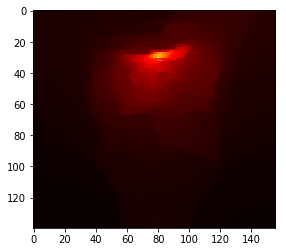

--
alpha: 2^-17
Correlation: 0.0124315430895
Score: 0.0048447107154
Heatmap:



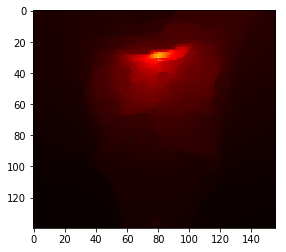

****


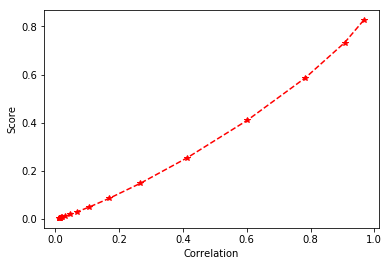

--------Seed [30, 110]
Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.98019498373
Score: 0.862103221193
Heatmap:



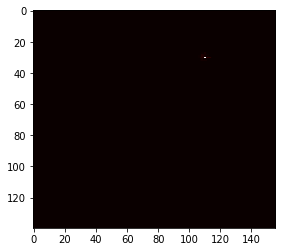

--
alpha: 2^-1
Correlation: 0.949803424799
Score: 0.81399854099
Heatmap:



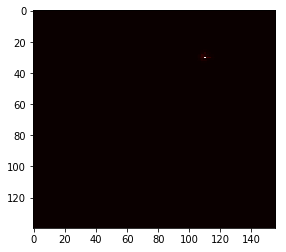

--
alpha: 2^-2
Correlation: 0.887797526704
Score: 0.738294088045
Heatmap:



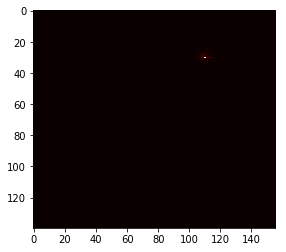

--
alpha: 2^-3
Correlation: 0.777752799309
Score: 0.625346083448
Heatmap:



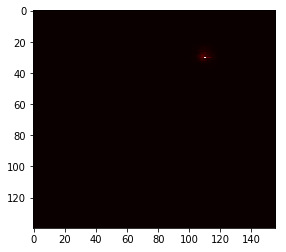

--
alpha: 2^-4
Correlation: 0.612565810503
Score: 0.47414121167
Heatmap:



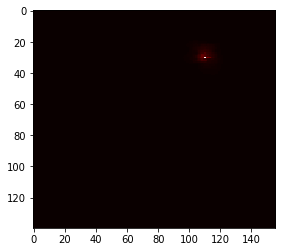

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.419530657924
Score: 0.311057794377
Heatmap:



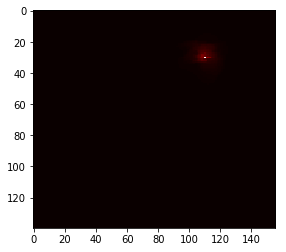

--
alpha: 2^-6
Correlation: 0.254520146287
Score: 0.180148033089
Heatmap:



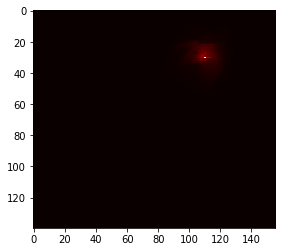

--
alpha: 2^-7
Correlation: 0.143667451508
Score: 0.0969254678925
Heatmap:



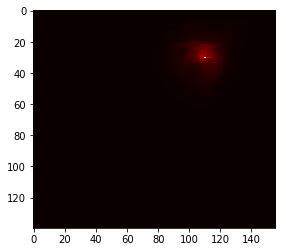

--
alpha: 2^-8
Correlation: 0.0792632876965
Score: 0.0510074161457
Heatmap:



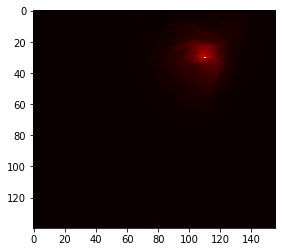

--
alpha: 2^-9
Correlation: 0.0438477223483
Score: 0.0269703167941
Heatmap:



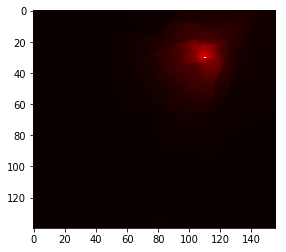

--
alpha: 2^-10
Correlation: 0.0247038844331
Score: 0.0145718292575
Heatmap:



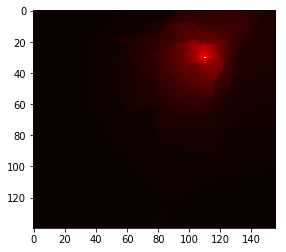

--
alpha: 2^-11
Correlation: 0.0147722121038
Score: 0.00841601693149
Heatmap:



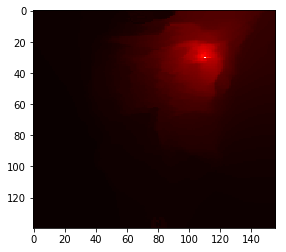

--
alpha: 2^-12
Correlation: 0.00929199459769
Score: 0.00515266097948
Heatmap:



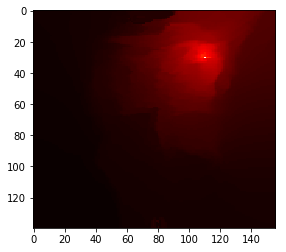

--
alpha: 2^-13
Correlation: 0.00651851522312
Score: 0.00355447767586
Heatmap:



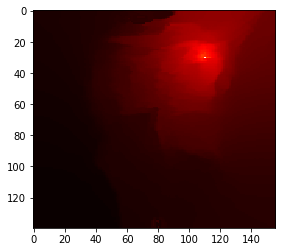

--
alpha: 2^-14
Correlation: 0.00523031483079
Score: 0.00282836421206
Heatmap:



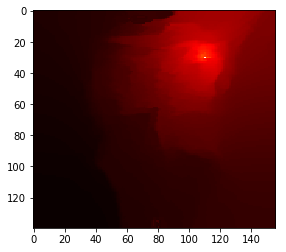

--
alpha: 2^-15
Correlation: 0.00420309764678
Score: 0.00225946105351
Heatmap:



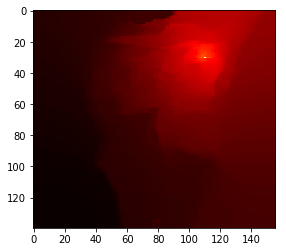

--
alpha: 2^-16
Correlation: 0.00380951416433
Score: 0.00204379077983
Heatmap:



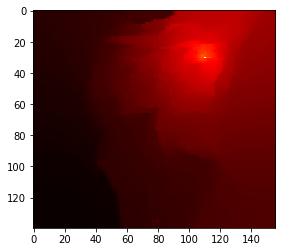

--
alpha: 2^-17
Correlation: 0.00357900760417
Score: 0.00191818036657
Heatmap:



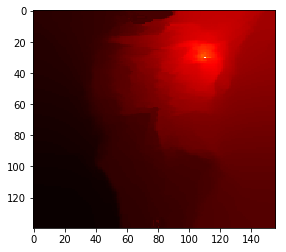

--
alpha: 2^-18
Correlation: 0.00349642129445
Score: 0.00187334762679
Heatmap:



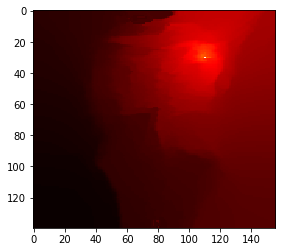

--
alpha: 2^-19
Correlation: 0.00337976433498
Score: 0.00180998404263
Heatmap:



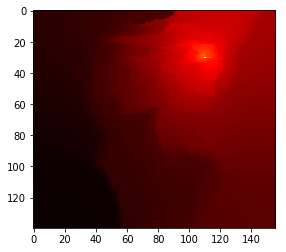

--
alpha: 2^-20
Correlation: 0.00327620181721
Score: 0.00175410969133
Heatmap:



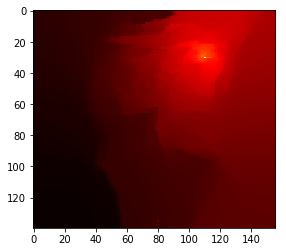

--
alpha: 2^-21
Correlation: 0.00350285631027
Score: 0.00187662179363
Heatmap:



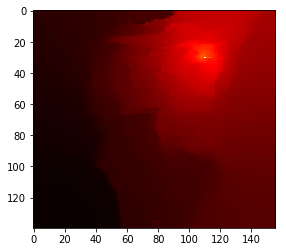

****


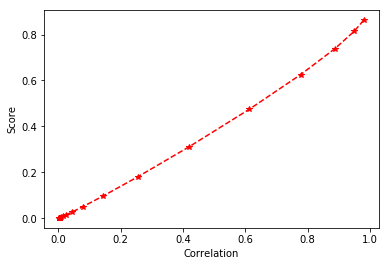

--------Seed [62, 50]
Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.982342956496
Score: 0.880590952914
Heatmap:



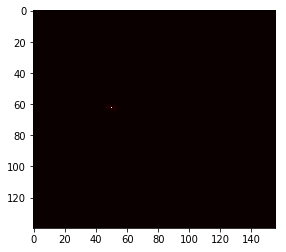

--
alpha: 2^-1
Correlation: 0.951985944813
Score: 0.832207645171
Heatmap:



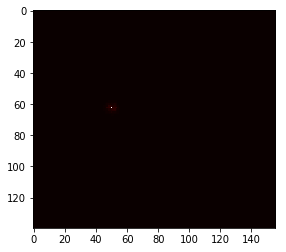

--
alpha: 2^-2
Correlation: 0.881583478299
Score: 0.745297108023
Heatmap:



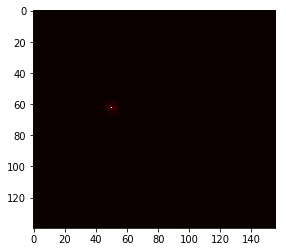

--
alpha: 2^-3
Correlation: 0.745381519617
Score: 0.603606297285
Heatmap:



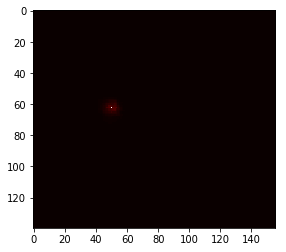

--
alpha: 2^-4
Correlation: 0.548255295972
Score: 0.421136202951
Heatmap:



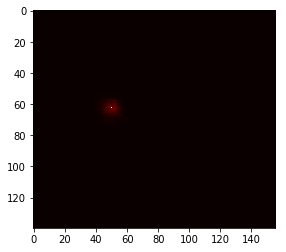

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.349863943396
Score: 0.253030450874
Heatmap:



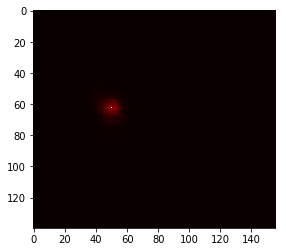

--
alpha: 2^-6
Correlation: 0.204285911507
Score: 0.138663667647
Heatmap:



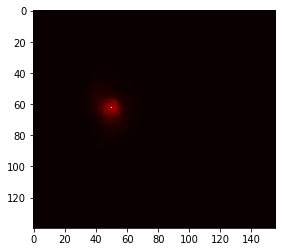

--
alpha: 2^-7
Correlation: 0.115719655881
Score: 0.0737930939846
Heatmap:



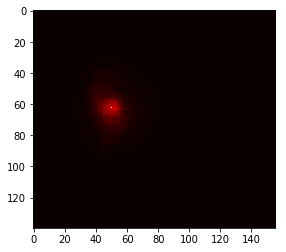

--
alpha: 2^-8
Correlation: 0.066268282856
Score: 0.0399103185738
Heatmap:



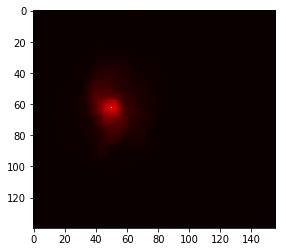

--
alpha: 2^-9
Correlation: 0.0407182933599
Score: 0.0234470252831
Heatmap:



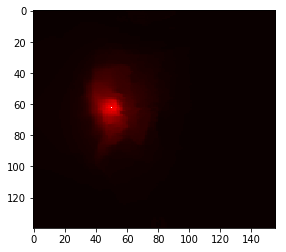

--
alpha: 2^-10
Correlation: 0.0265417240236
Score: 0.0147814735304
Heatmap:



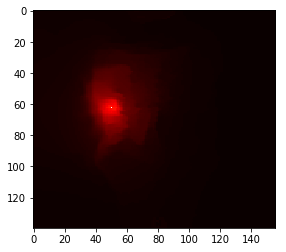

--
alpha: 2^-11
Correlation: 0.0169983795335
Score: 0.00921128091612
Heatmap:



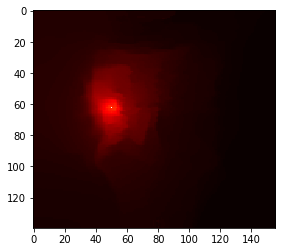

--
alpha: 2^-12
Correlation: 0.0131009628375
Score: 0.00701347752747
Heatmap:



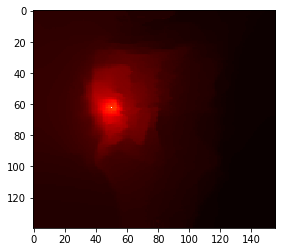

--
alpha: 2^-13
Correlation: 0.00961646421828
Score: 0.005086932396
Heatmap:



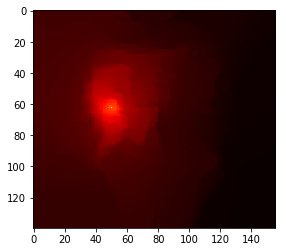

--
alpha: 2^-14
Correlation: 0.00708746478247
Score: 0.00371603184429
Heatmap:



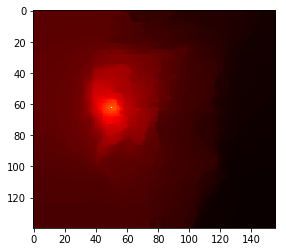

--
alpha: 2^-15
Correlation: 0.00578759371023
Score: 0.00302080928069
Heatmap:



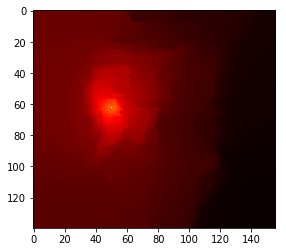

--
alpha: 2^-16
Correlation: 0.0052425950457
Score: 0.00273190562569
Heatmap:



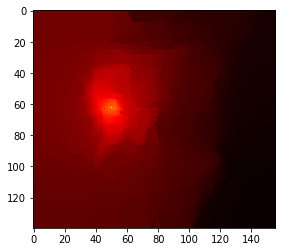

--
alpha: 2^-17
Correlation: 0.00500097857349
Score: 0.00260337556511
Heatmap:



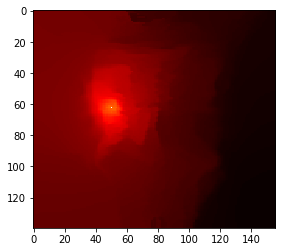

--
alpha: 2^-18
Correlation: 0.00440998619248
Score: 0.00229327302971
Heatmap:



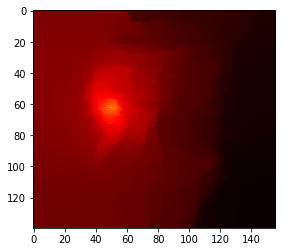

--
alpha: 2^-19
Correlation: 0.00451276359037
Score: 0.00234727015389
Heatmap:



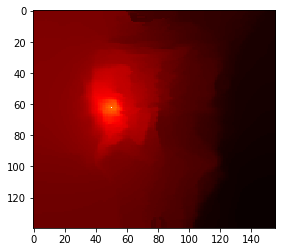

****


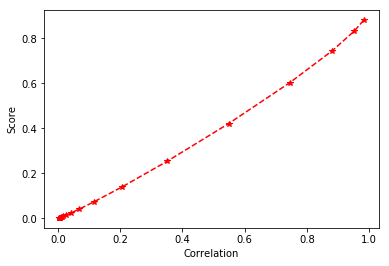

--------Seed [62, 80]
Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.970840938743
Score: 0.788334942145
Heatmap:



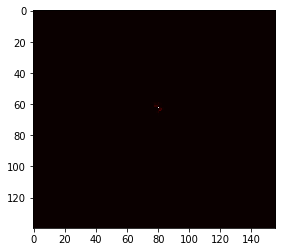

--
alpha: 2^-1
Correlation: 0.930687894291
Score: 0.727130947263
Heatmap:



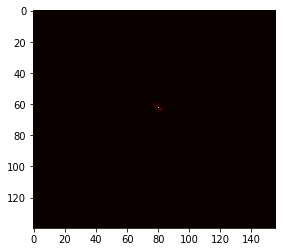

--
alpha: 2^-2
Correlation: 0.858622920303
Score: 0.643918342298
Heatmap:



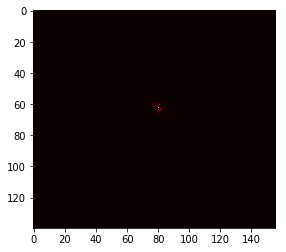

--
alpha: 2^-3
Correlation: 0.748102185995
Score: 0.53861783443
Heatmap:



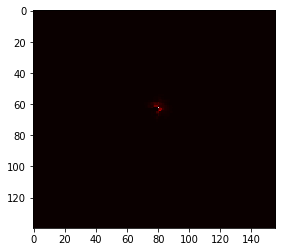

--
alpha: 2^-4
Correlation: 0.603477450261
Score: 0.417622936055
Heatmap:



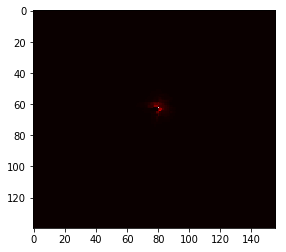

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.448882372349
Score: 0.299432727293
Heatmap:



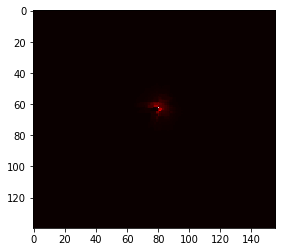

--
alpha: 2^-6
Correlation: 0.313378987374
Score: 0.202419788361
Heatmap:



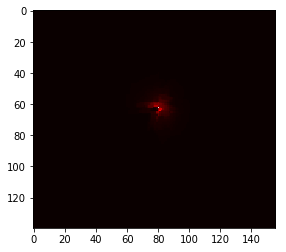

--
alpha: 2^-7
Correlation: 0.208533640679
Score: 0.131021152044
Heatmap:



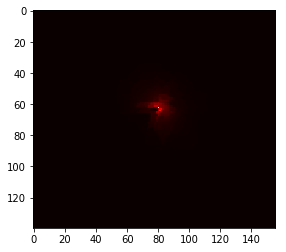

--
alpha: 2^-8
Correlation: 0.132193116695
Score: 0.0810443109102
Heatmap:



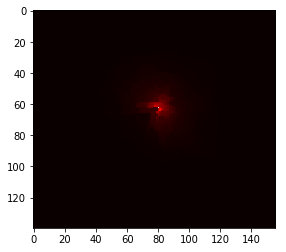

--
alpha: 2^-9
Correlation: 0.0811709309209
Score: 0.0486873737429
Heatmap:



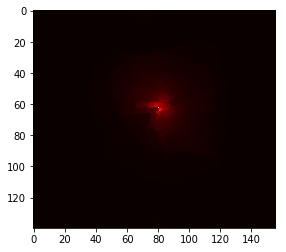

--
alpha: 2^-10
Correlation: 0.0489633478192
Score: 0.0288051763313
Heatmap:



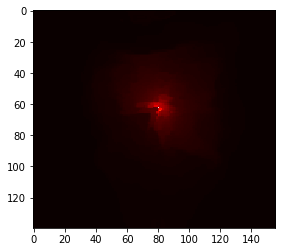

--
alpha: 2^-11
Correlation: 0.0320545580892
Score: 0.0186050682386
Heatmap:



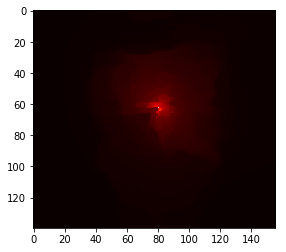

--
alpha: 2^-12
Correlation: 0.0232118500942
Score: 0.0133652808937
Heatmap:



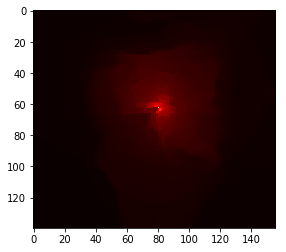

--
alpha: 2^-13
Correlation: 0.0186684322462
Score: 0.0107083628386
Heatmap:



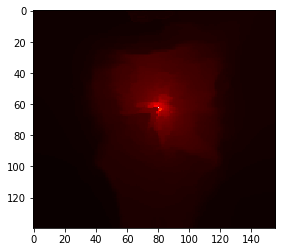

--
alpha: 2^-14
Correlation: 0.016437022612
Score: 0.00941353811736
Heatmap:



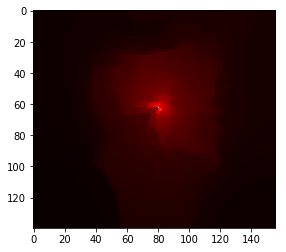

--
alpha: 2^-15
Correlation: 0.0151077145328
Score: 0.00864526176906
Heatmap:



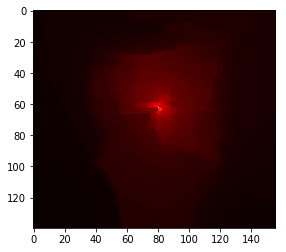

--
alpha: 2^-16
Correlation: 0.0144609789004
Score: 0.00827138827701
Heatmap:



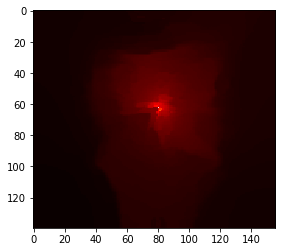

--
alpha: 2^-17
Correlation: 0.0141676947306
Score: 0.00810397924718
Heatmap:



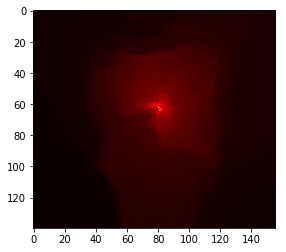

--
alpha: 2^-18
Correlation: 0.0142198815344
Score: 0.00813371980934
Heatmap:



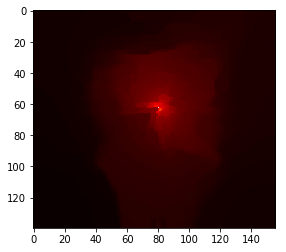

****


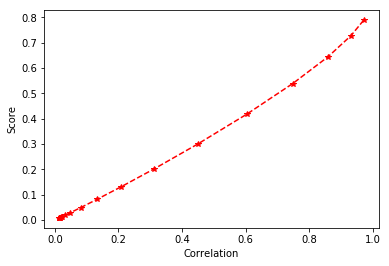

--------Seed [62, 110]
Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.973594048533
Score: 0.859456956509
Heatmap:



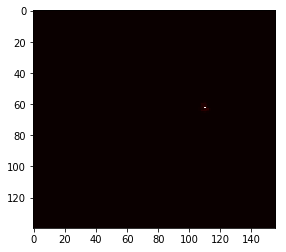

--
alpha: 2^-1
Correlation: 0.926713149495
Score: 0.785126035539
Heatmap:



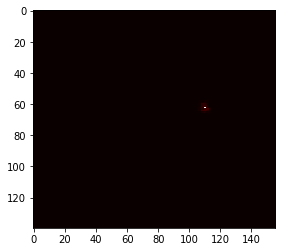

--
alpha: 2^-2
Correlation: 0.826980954333
Score: 0.66358503496
Heatmap:



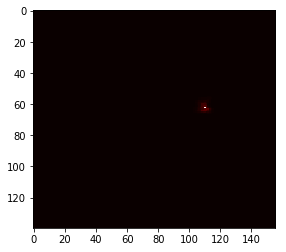

--
alpha: 2^-3
Correlation: 0.668232128826
Score: 0.502941629862
Heatmap:



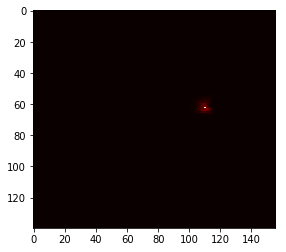

--
alpha: 2^-4
Correlation: 0.485155501035
Score: 0.341245407831
Heatmap:



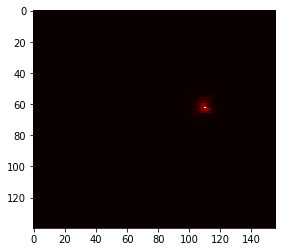

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.327760431087
Score: 0.216303980577
Heatmap:



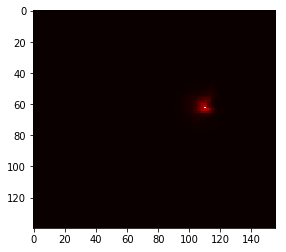

--
alpha: 2^-6
Correlation: 0.213007499447
Score: 0.132867949983
Heatmap:



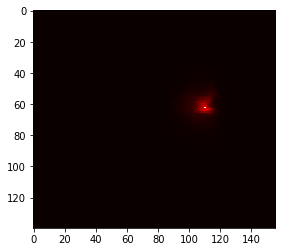

--
alpha: 2^-7
Correlation: 0.13371339049
Score: 0.079312013133
Heatmap:



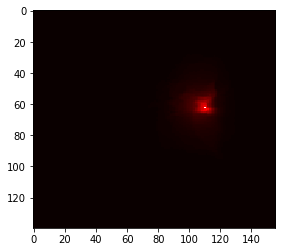

--
alpha: 2^-8
Correlation: 0.0805879116243
Score: 0.0456127607019
Heatmap:



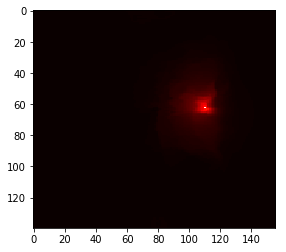

--
alpha: 2^-9
Correlation: 0.0481911356814
Score: 0.0261540679063
Heatmap:



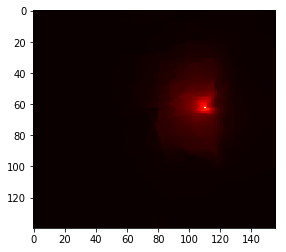

--
alpha: 2^-10
Correlation: 0.0297746487399
Score: 0.0156060579468
Heatmap:



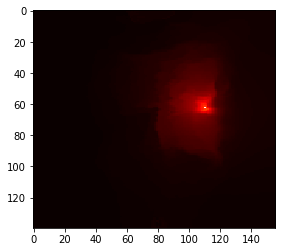

--
alpha: 2^-11
Correlation: 0.0171822215614
Score: 0.00870617674571
Heatmap:



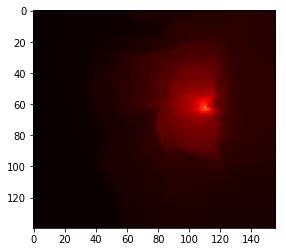

--
alpha: 2^-12
Correlation: 0.0125033984197
Score: 0.00623323656043
Heatmap:



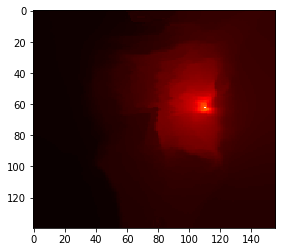

--
alpha: 2^-13
Correlation: 0.00809035217732
Score: 0.00395858674077
Heatmap:



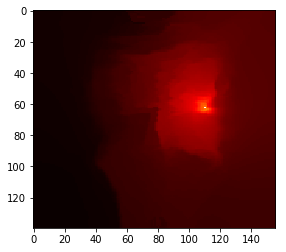

--
alpha: 2^-14
Correlation: 0.00599120363134
Score: 0.00290123203712
Heatmap:



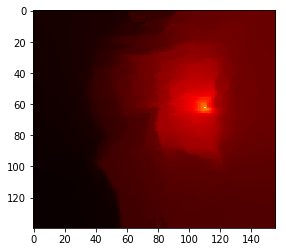

--
alpha: 2^-15
Correlation: 0.00501675848301
Score: 0.00241742642238
Heatmap:



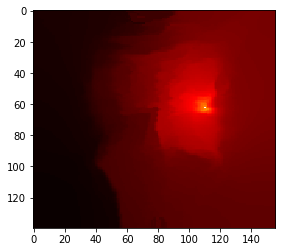

--
alpha: 2^-16
Correlation: 0.00440790814718
Score: 0.00211764731195
Heatmap:



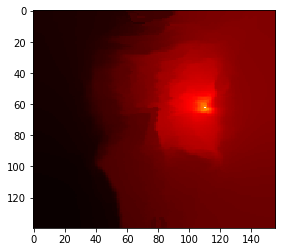

--
alpha: 2^-17
Correlation: 0.00396020243286
Score: 0.0018995233963
Heatmap:



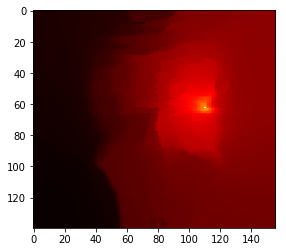

--
alpha: 2^-18
Correlation: 0.00382965546165
Score: 0.00183606192928
Heatmap:



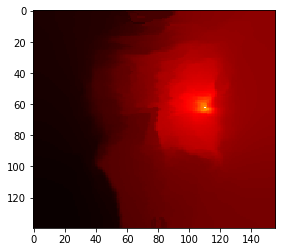

--
alpha: 2^-19
Correlation: 0.00353165166651
Score: 0.00169179118557
Heatmap:



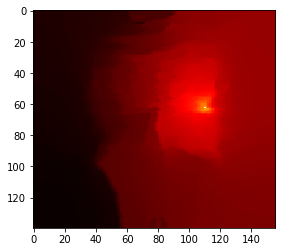

--
alpha: 2^-20
Correlation: 0.00377573844791
Score: 0.00180970792299
Heatmap:



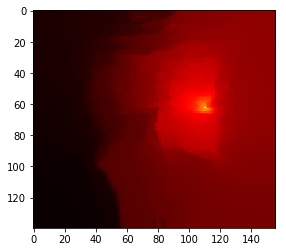

****


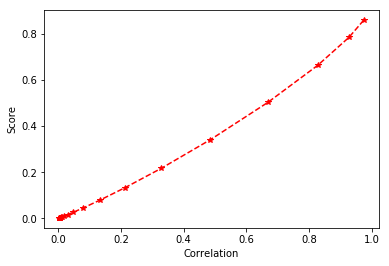

--------Seed [94, 50]
Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.977037951626
Score: 0.844124922537
Heatmap:



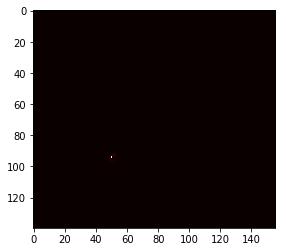

--
alpha: 2^-1
Correlation: 0.942472319923
Score: 0.789863914716
Heatmap:



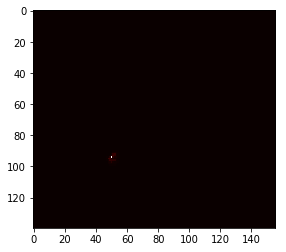

--
alpha: 2^-2
Correlation: 0.874040921785
Score: 0.707399528847
Heatmap:



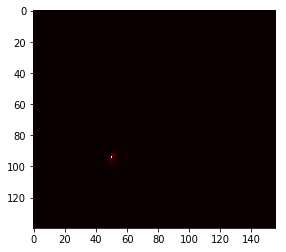

--
alpha: 2^-3
Correlation: 0.757620573087
Score: 0.590117160115
Heatmap:



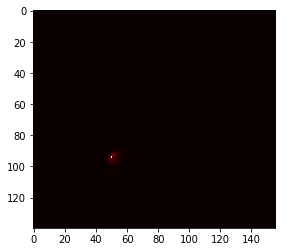

--
alpha: 2^-4
Correlation: 0.589533961148
Score: 0.439985567484
Heatmap:



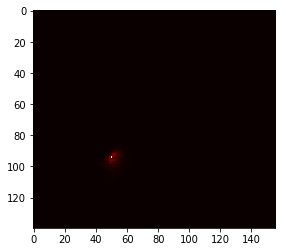

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.399815587634
Score: 0.284457396883
Heatmap:



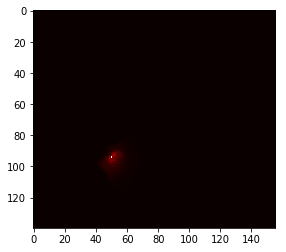

--
alpha: 2^-6
Correlation: 0.239048330654
Score: 0.161343966501
Heatmap:



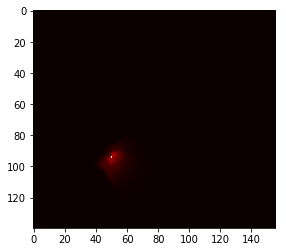

--
alpha: 2^-7
Correlation: 0.132763025961
Score: 0.0847596987727
Heatmap:



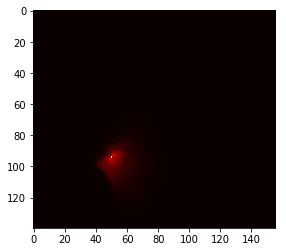

--
alpha: 2^-8
Correlation: 0.0722693931786
Score: 0.043639452268
Heatmap:



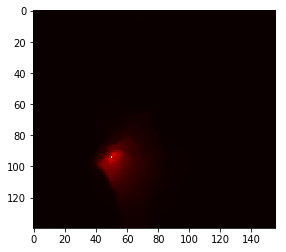

--
alpha: 2^-9
Correlation: 0.0401096806031
Score: 0.0229804512226
Heatmap:



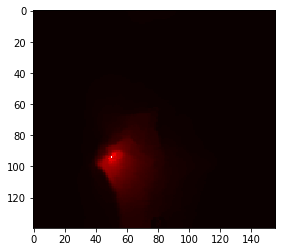

--
alpha: 2^-10
Correlation: 0.0224988961832
Score: 0.0122668111328
Heatmap:



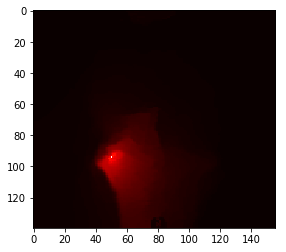

--
alpha: 2^-11
Correlation: 0.0135401147692
Score: 0.00709481064941
Heatmap:



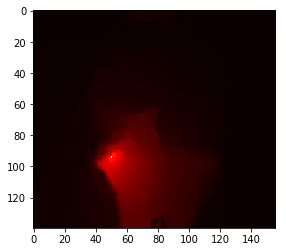

--
alpha: 2^-12
Correlation: 0.00932807626103
Score: 0.0047712220472
Heatmap:



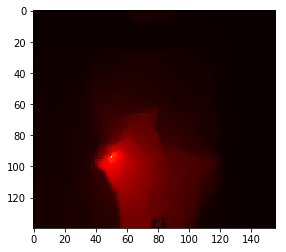

--
alpha: 2^-13
Correlation: 0.00721777747659
Score: 0.0036467479387
Heatmap:



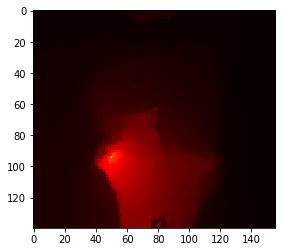

--
alpha: 2^-14
Correlation: 0.00608980779226
Score: 0.00306074251321
Heatmap:



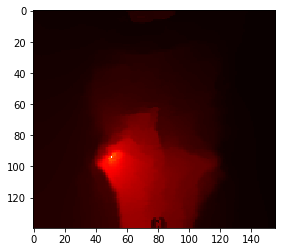

--
alpha: 2^-15
Correlation: 0.00561096378882
Score: 0.0028156823662
Heatmap:



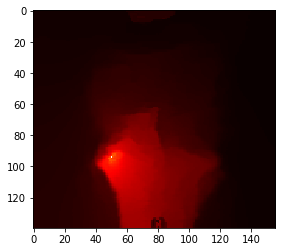

--
alpha: 2^-16
Correlation: 0.00534604778103
Score: 0.00268122825745
Heatmap:



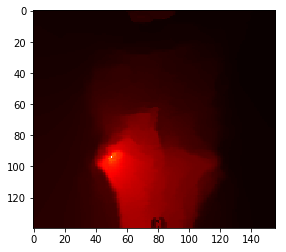

--
alpha: 2^-17
Correlation: 0.00532402850085
Score: 0.00267004354674
Heatmap:



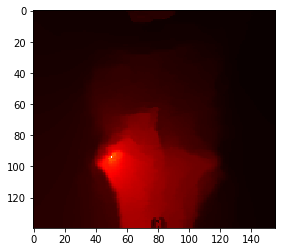

****


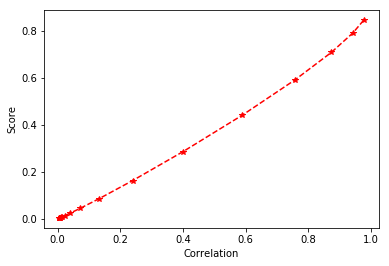

--------Seed [94, 80]
Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.971636391376
Score: 0.830778128186
Heatmap:



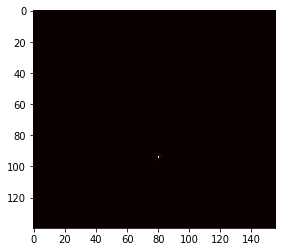

--
alpha: 2^-1
Correlation: 0.92117349382
Score: 0.752118002793
Heatmap:



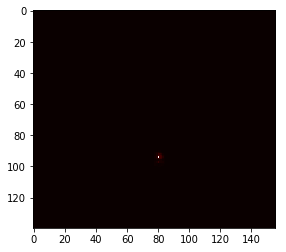

--
alpha: 2^-2
Correlation: 0.817112749651
Score: 0.628281893552
Heatmap:



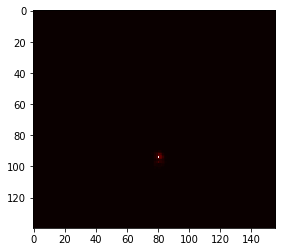

--
alpha: 2^-3
Correlation: 0.656369738271
Score: 0.470538402992
Heatmap:



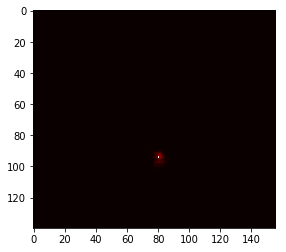

--
alpha: 2^-4
Correlation: 0.480172275567
Score: 0.320712838863
Heatmap:



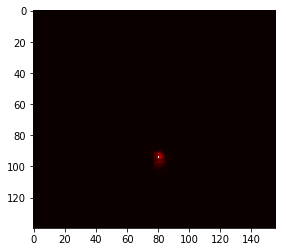

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.335862968194
Score: 0.211054291283
Heatmap:



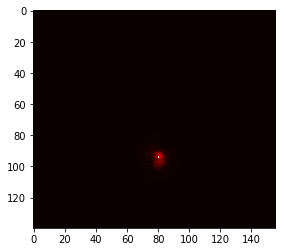

--
alpha: 2^-6
Correlation: 0.232441865429
Score: 0.139246423508
Heatmap:



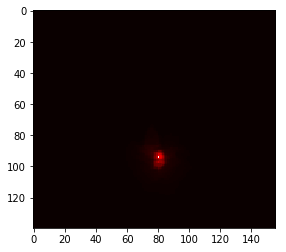

--
alpha: 2^-7
Correlation: 0.158096816918
Score: 0.0911768968621
Heatmap:



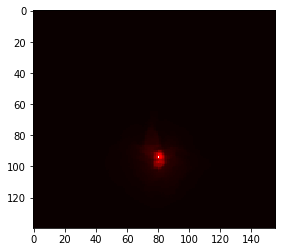

--
alpha: 2^-8
Correlation: 0.101430844047
Score: 0.0565173490132
Heatmap:



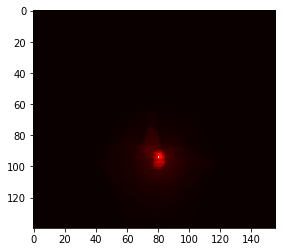

--
alpha: 2^-9
Correlation: 0.0593008948624
Score: 0.0318838291606
Heatmap:



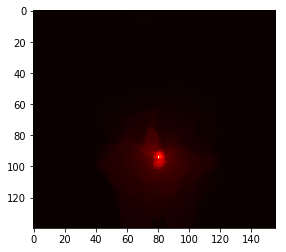

--
alpha: 2^-10
Correlation: 0.0314494195559
Score: 0.0162488289878
Heatmap:



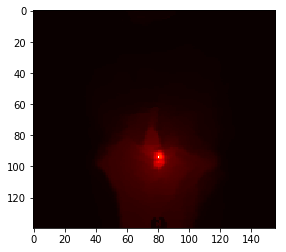

--
alpha: 2^-11
Correlation: 0.0174992308136
Score: 0.00872703950924
Heatmap:



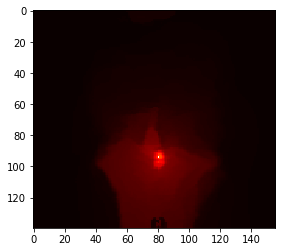

--
alpha: 2^-12
Correlation: 0.0112861294549
Score: 0.00549996398685
Heatmap:



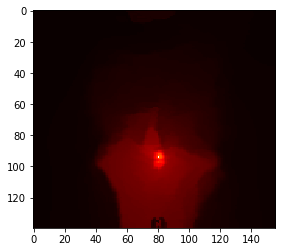

--
alpha: 2^-13
Correlation: 0.0084463652747
Score: 0.00406886609139
Heatmap:



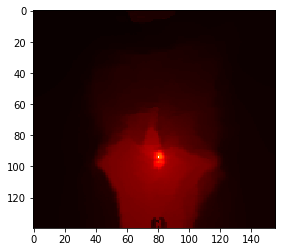

--
alpha: 2^-14
Correlation: 0.0071204348514
Score: 0.00341458548459
Heatmap:



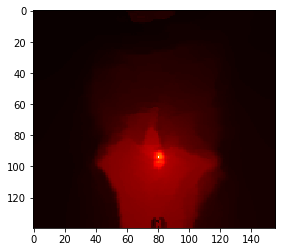

--
alpha: 2^-15
Correlation: 0.00650098337928
Score: 0.00311287645526
Heatmap:



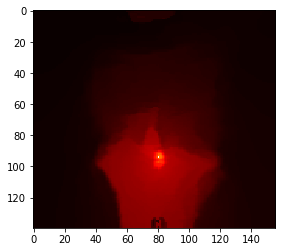

--
alpha: 2^-16
Correlation: 0.00619833490831
Score: 0.00296622902957
Heatmap:



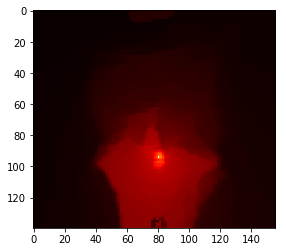

--
alpha: 2^-17
Correlation: 0.00605943273087
Score: 0.00289959207364
Heatmap:



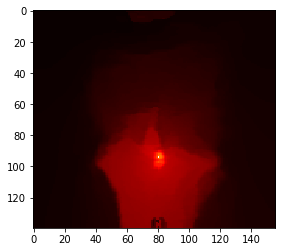

--
alpha: 2^-18
Correlation: 0.00593304610207
Score: 0.00283847156864
Heatmap:



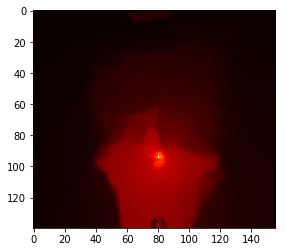

--
alpha: 2^-19
Correlation: 0.00589812707125
Score: 0.00282173560763
Heatmap:



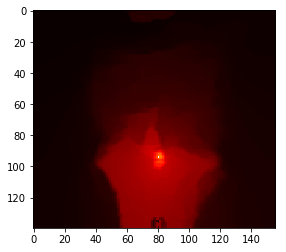

****


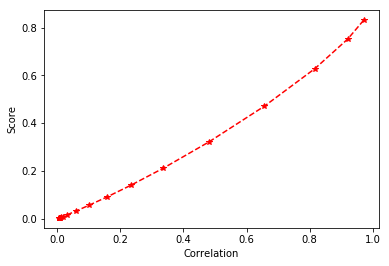

--------Seed [94, 110]
Threshold: 4.578754578754579e-05
--
alpha: 2^0
Correlation: 0.965461121524
Score: 0.793421320066
Heatmap:



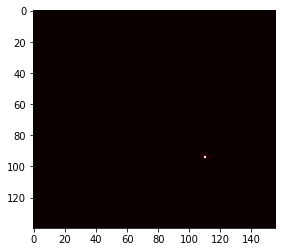

--
alpha: 2^-1
Correlation: 0.906434344746
Score: 0.703121436411
Heatmap:



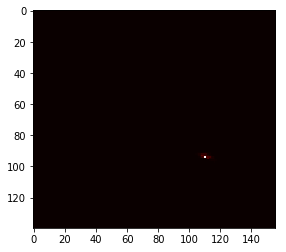

--
alpha: 2^-2
Correlation: 0.787764755842
Score: 0.566065290694
Heatmap:



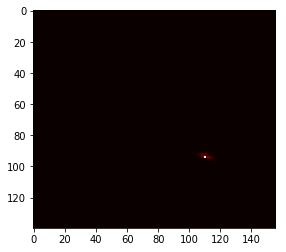

--
alpha: 2^-3
Correlation: 0.610777039319
Score: 0.400005387705
Heatmap:



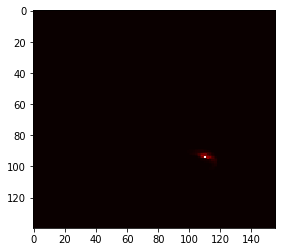

--
alpha: 2^-4
Correlation: 0.422950193911
Score: 0.250177919516
Heatmap:



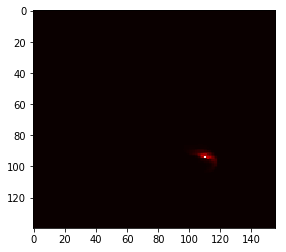

**
Starting correlation decrease check!
--
alpha: 2^-5
Correlation: 0.277816313278
Score: 0.149217247877
Heatmap:



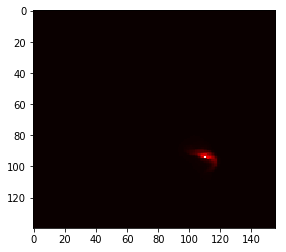

--
alpha: 2^-6
Correlation: 0.186482309935
Score: 0.0928448457004
Heatmap:



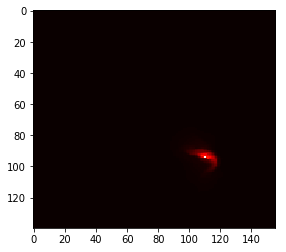

--
alpha: 2^-7
Correlation: 0.13158381588
Score: 0.0622179414475
Heatmap:



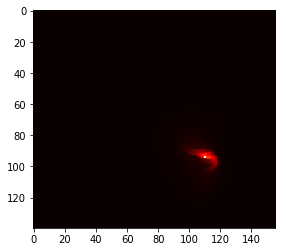

--
alpha: 2^-8
Correlation: 0.0954663773611
Score: 0.0436068050528
Heatmap:



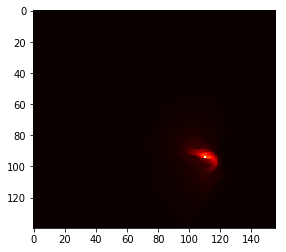

--
alpha: 2^-9
Correlation: 0.0685973540463
Score: 0.0305477000405
Heatmap:



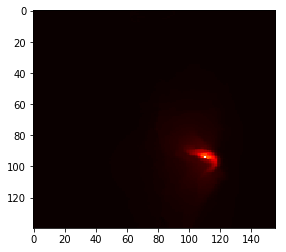

--
alpha: 2^-10
Correlation: 0.0463453962584
Score: 0.0201918056501
Heatmap:



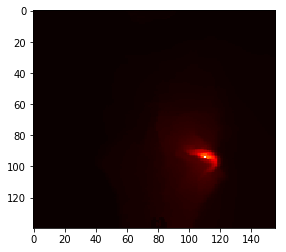

--
alpha: 2^-11
Correlation: 0.0322291299804
Score: 0.0138261914181
Heatmap:



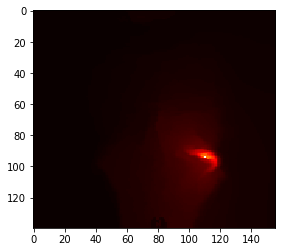

--
alpha: 2^-12
Correlation: 0.022078759454
Score: 0.00935061246808
Heatmap:



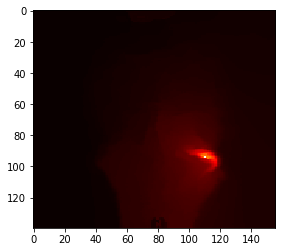

--
alpha: 2^-13
Correlation: 0.0152134491796
Score: 0.00637974865129
Heatmap:



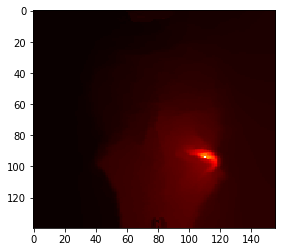

--
alpha: 2^-14
Correlation: 0.0119565815966
Score: 0.0049908985457
Heatmap:



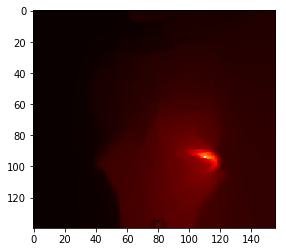

--
alpha: 2^-15
Correlation: 0.00999510975349
Score: 0.00416083466224
Heatmap:



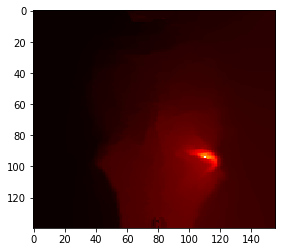

--
alpha: 2^-16
Correlation: 0.00880063464374
Score: 0.00365831080013
Heatmap:



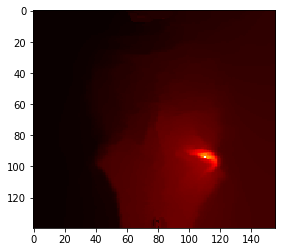

--
alpha: 2^-17
Correlation: 0.00859266833877
Score: 0.00357116784775
Heatmap:



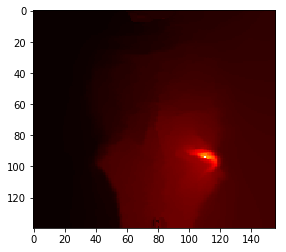

--
alpha: 2^-18
Correlation: 0.00824012206242
Score: 0.0034226901003
Heatmap:



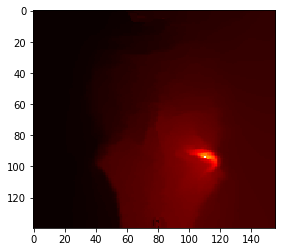

--
alpha: 2^-19
Correlation: 0.00798236197587
Score: 0.00331567997904
Heatmap:



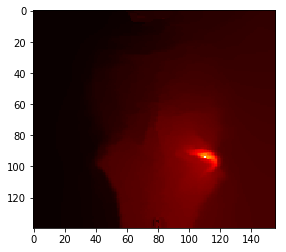

--
alpha: 2^-20
Correlation: 0.00822174146466
Score: 0.0034156356124
Heatmap:



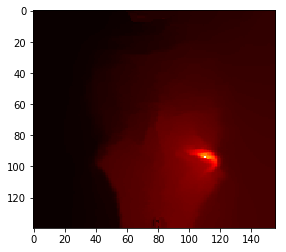

****


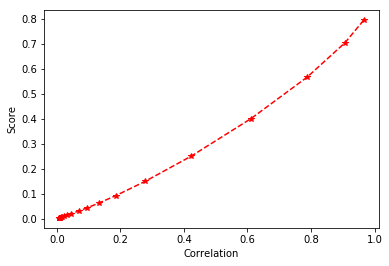

In [6]:
for elem in seedList[2:]:
    print('--------Seed ' + str(elem))
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    
    [alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

    # Saving
    alphaListList.append(alphaList)
    correlationListList.append(correlationList)
    scoreListList.append(scoreList)
    valueListList.append(valueList)

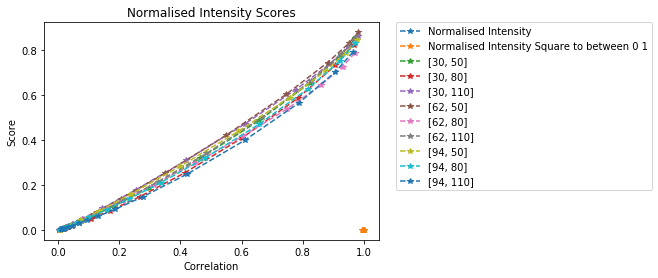

In [7]:
for i in range(len(correlationListList)):
    plt.plot(correlationListList[i], scoreListList[i], '*--')
plt.legend(seedList, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

In [8]:
save_array(IMAGE + '/' + 'alphaListList.data', alphaListList)
save_array(IMAGE + '/' + 'correlationListList.data', correlationListList)
save_array(IMAGE + '/' + 'scoreListList.data', scoreListList)
save_array(IMAGE + '/' + 'valueListList.data', valueListList)
save_array(IMAGE + '/' + 'seedList.data', seedList[2:])

In [9]:
alphaListListRecovered = load_array(IMAGE + '/' + 'alphaListList.data')
correlationListListRecovered = load_array(IMAGE + '/' + 'correlationListList.data')
scoreListListRecovered = load_array(IMAGE + '/' + 'scoreListList.data')
valueListListRecovered = load_array(IMAGE + '/' + 'valueListList.data')
seedListRecovered = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1']
seedListRecovered[2:] = load_array(IMAGE + '/' + 'seedList.data')

Print with saved arrays for future usage


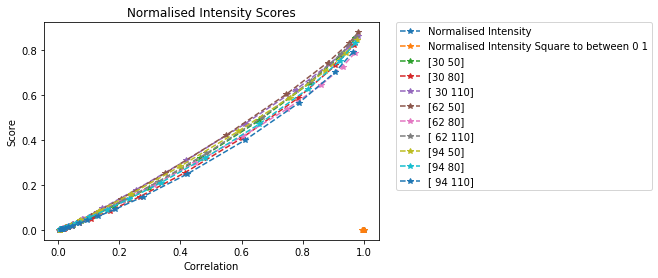

In [11]:
print('Print with saved arrays for future usage')
for i in range(len(correlationListListRecovered)):
    plt.plot(correlationListListRecovered[i], scoreListListRecovered[i], '*--')
plt.legend(seedListRecovered, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
# plt.axis([.8,1,0,1])
plt.show()